In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unidecode
import geopandas as gpd
import seaborn as sns
from datetime import datetime
from ibge.localidades import Municipios

In [2]:
# Obtendo e Modelando os dados
path = r'/home/hector/Documentos/Fatec/Integrador2/dados.TXT'
pathGeo = r'/home/hector/Documentos/Fatec/Integrador2/BRMUE250GC_SIR.shp'

# Pegando dados com de registros para Análise
datas = pd.read_fwf(path, header=None)
datas[0]= datas[0].str.replace('"','')
df_data = datas[0].str.split('[|]', expand = True)
df_data = pd.DataFrame(df_data)

# Pegando dados dos municipios com a Api do IBGE
dados_municipios = Municipios()
df_muni = pd.DataFrame(dados_municipios.getDados())

# Carregando Geodataframe com os Poligonos -> Shape Brasil
df_brasil = gpd.read_file(pathGeo)
df_brasil = df_brasil.set_geometry('geometry')

In [3]:
# Bloco de Funções utilizadas no Análise

# função para Formatar datas -> ex: 2022/06/12
def formatDate(date):
    if (int(date[0:4]) > 1000 and int(date[0:4]) < 2002) and (int(date[4:6]) >= 1 and int(date[4:6]) <= 12) and (int(date[6:]) >= 1 and int(date[6:]) <= 31):
        return f'{date[0:4]}/{date[4:6]}/{date[6:]}'
    else:
        return  f'{date[4:]}/{date[2:4]}/{date[0:2]}'
    
# função para formatar rótulos do grafico dos sexos    
def labelChart(pct, val):
    total = round(pct/100 * np.sum(val))
    return f'{pct:.1f}%\n ({total})'

# função para estilizando DataFrames 
def styleFrame(df, title, colors='Greens'):
    props = ['background-color: #12330b; color: white; font-weight: 600']
    df = df.style.background_gradient(cmap=colors).highlight_max(props=props).set_caption(title)
    df = df.set_table_styles([
        {'selector': 'caption', 'props': 'font-size: 14px; font-weight: bold; text-align: center'}
    ])
    return df

# função para contar registros
def count_records(dataDictionary, nameColumn, title):
    dataDictionary = pd.DataFrame(list(dataDictionary.items()), columns=[nameColumn, 'Qtd_Registros'])
    dataDictionary = dataDictionary.append({nameColumn : 'TOTAL',
    'Qtd_Registros': dataDictionary['Qtd_Registros'].sum()}, ignore_index=True )
    return styleFrame(dataDictionary, title)


#função para tratar e calcular digito verificador
def calculaDigito(CPF1):
    CPF1 = cpf[-11:]
    #dv1
    if (CPF1[9]) == '0' and (CPF1[10]) == '0' :
        CPF1 = (CPF1[:9])
    else:
        CPF1 = (CPF1[:9])
    resultado = 0
    for i in range(10,1,-1):
        resultado += int(CPF1[-(i-1)])*i
    dv1=11-(resultado%11)
    if dv1 >= 10:
        dv1 = 0
    #dv2
    CPF2 = str(CPF1) + str(dv1)
    CPF2
    resultado = 0
    for i in range(10,1,-1):
        resultado += int( CPF2[-(i-1)] ) *i
    resultado 
    dv2 = 11-resultado%11
    if dv2 >= 10:
        dv2 = 0
    #junta tudo 
    CPF3 = str(CPF1) + str(dv1) + str(dv2)
    return CPF3

def formatMuniNome(nomeMunicpio):
    pps = ['Do', 'De', 'Da', 'Dos', 'Das', 'Dos']
    city = str(nomeMunicpio).title()
    city = city.split(' ')
    city = [ct.lower() if (len(ct) <= 3 and ct[0] == 'D' and ct in pps) else ct for ct in city ]
    city =" ".join(city)
    return city

In [4]:
# Renomeando colunas 
df_data.rename(columns = { 0 : 'CPF' , 1 : 'Região', 2: 'Nasc', 3:'Sexo',
4:'Classe', 5:'Bairro', 6:'CEP', 7:'Cidade', 8:'UF' },inplace=True)

# Removendo duplicadas
# df_data.duplicated()
# df_data.drop_duplicates()

In [5]:
# Formatando datas para modelo YY/mm/dd
for i in range(0, len(df_data["Nasc"])):
    dateFormated = formatDate(df_data["Nasc"][i])
    df_data["Nasc"][i] = dateFormated

In [6]:
# Filtrando e Contabilizando dados da região sudeste 
df_dataSudeste = pd.DataFrame.copy(df_data.loc[df_data['Região'] == 'SUDESTE'])
registerAccounting = dict(df_dataSudeste['UF'].value_counts())
registerAccounting['Indefinido'] = registerAccounting.pop('')
registerAccounting = count_records(registerAccounting, 'UF', 'Registros por Estados')
display(registerAccounting)

,UF,Qtd_Registros
0,SP,869
1,RJ,186
2,MG,64
3,ES,37
4,S,3
5,Indefinido,2
6,TOTAL,1161


In [7]:
#verificar/dropar quem nasceu antes de 1907
for index in df_dataSudeste.index:
    ano = df_dataSudeste["Nasc"][index][:4]
    df_dataSudeste.loc[index, "ano"] = int(ano)
    
df_dataSudeste = df_dataSudeste.query("ano > 1907")
df_dataSudeste = df_dataSudeste.drop(columns=["ano"])

In [8]:
#Tratando digíto verificador (CPF)
for index in df_dataSudeste.index:
    cpf = df_dataSudeste["CPF"][index]
    df_dataSudeste.loc[index,"CPF"] = calculaDigito(cpf)

In [9]:
# Coletando Registros por UFs 

x = [uf for uf in df_dataSudeste['UF'].value_counts().index]
y = [uf for uf in df_dataSudeste['UF'].value_counts()]
posicao = [psc for psc in range(0,len(y))][::-1]

# fig, ax = plt.subplots(figsize=(8,6))
# sns.barplot(x=x[::-1], y=y[::-1] , data=df_dataSudeste['UF'],palette='YlGnBu')

# ax.set_title("Registros x UF", fontdict={'fontsize':15, 'weight':'600'})
# ax.set_xlabel('UF', fontdict={'fontsize':14, 'weight':'600'})
# ax.set_ylabel('Registros', fontdict={'fontsize':14, 'weight':'600'})
# ax.tick_params(labelsize=14)
# ax.spines['bottom'].set_linewidth(2.5)

# for axis in ['top', 'right', 'left']:
#     ax.spines[axis].set_color(None)
    
# ax.tick_params(axis='y', labelleft=False, left=None)                  

# for i in range(0, len(df_dataSudeste['UF'].value_counts())):
#     ax.text(x=posicao[i]-0.14, y=y[i]+20, s=str(y[i]),fontsize=14, weight=400)

# fig.tight_layout();

In [10]:
#Identificando e Contabilizando Sexos

# j = df_dataSudeste['Sexo'].value_counts().values
# u = df_dataSudeste['Sexo'].value_counts().index
# sexos = ['Masculino', 'Feminino', 'Indefinido']

# plt.figure(figsize = (24, 10))
# plt.subplot(1, 4, 2)
# plt.title("Contabilização Sexos", weight='bold', size=14)
# wedges, texts, autotexts = plt.pie(j, labels = sexos,  
#         colors = [ "#012030", "#13678A", "#45C4B0"],
#         labeldistance = 1.1,
#         explode = [.0, .0, .0],
#         wedgeprops = {"ec": "w"}, 
#         textprops = {"fontsize": 12, "color": "k"}, 
#         autopct=lambda pct: labelChart(pct, j),
#         )

# plt.legend(title = 'Sexo' ,loc = 'center right', bbox_to_anchor=[1, 0.5, 0.2, 0.7])
# plt.setp(autotexts,size=10, weight='bold', color='w')
# plt.show()

In [11]:
df_dataSudeste
rg = df_dataSudeste.loc[df_dataSudeste['UF'] == 'SP']
rg = dict(rg.Classe.value_counts())
rg = count_records(rg, 'Classes', 'Registros por Classes')
rg

,Classes,Qtd_Registros
0,C,732
1,B,88
2,A,49
3,TOTAL,869


In [12]:
#Contabilizando Classes:
classAccounting = dict(df_dataSudeste.Classe.value_counts())
dr = count_records(classAccounting, 'Classes', 'Registros por Classes')
display(classAccounting)

{'C': 1007, 'B': 98, 'A': 58}

In [13]:
#Mas apliquei o algoritmo para excluir classes que não eram A,B ou C.
drp2 = df_dataSudeste[(df_dataSudeste["Classe"] != 'A') 
                      & (df_dataSudeste["Classe"] != 'B')  
                      & (df_dataSudeste["Classe"] != 'C')].index
df_classe= df_dataSudeste.drop(drp2)

In [14]:
# Formatando nome dos Municipios para junção - Dataframe: df_dataSudeste
pps = ['Do', 'De', 'Da', 'Dos', 'Das', 'Dos']

for index in df_dataSudeste.index:
    city = str(df_dataSudeste['Cidade'][index]).title()
    city = city.split(' ')
    city = [ct.lower() if (len(ct) <= 3 and ct[0] == 'D' and ct in pps) else ct for ct in city ]
    city =" ".join(city)
    df_dataSudeste.loc[index, 'Cidade'] = city

In [15]:
# Filtrando Dados dos municipios do Sudeste
ufs = [uf for uf in df_dataSudeste['UF'].value_counts().index]
ufs = list(filter(None, ufs))

df_muni = df_muni[df_muni.uf.isin(ufs)].reset_index(drop=True)
# Tirando caracteres especiais para realizar a junção - Dataframe: df_muni
for index in df_muni.index:
    city = unidecode.unidecode(str(df_muni['nome'][index]))
    df_muni.loc[index, 'nome'] = city

In [16]:
# Atribuindo coluna com o Código IBGE de cada município - Esperar a conclusão!!!
for index in df_dataSudeste.index:
    for idxMun in df_muni.index:
        if(df_dataSudeste.loc[index, 'Cidade'] == df_muni.loc[idxMun, 'nome']):
            df_dataSudeste.loc[index, 'Cod_Ibge'] = df_muni.loc[idxMun, 'ibge']
            break

In [17]:
# Contabilizando Municípios sem codigo IBGE
df_dataSudeste.fillna('0' ,inplace=True)
df_semIbge = dict(df_dataSudeste['UF'].loc[df_dataSudeste['Cod_Ibge'] == '0'].value_counts())
df_semIbge['Indefinido'] = df_semIbge.pop('0')
df_semIbge = count_records(df_semIbge, 'UF', 'Municípios com código IBGE não encontrado')

display(df_semIbge)

,UF,Qtd_Registros
0,SP,31
1,ES,17
2,MG,5
3,RJ,4
4,Indefinido,1
5,TOTAL,58


In [18]:
# Filtrando dados da região sudeste do Geodataframe 
maior = max([int(num) for num in df_dataSudeste['Cod_Ibge']])
menor = 3000000

df_brasil['CD_GEOCMU'] =  df_brasil['CD_GEOCMU'].astype(int)
df_shapeSudeste = gpd.geopandas.GeoDataFrame(df_brasil.query(f'CD_GEOCMU <= {maior} and CD_GEOCMU >= {menor} '))

In [19]:
# DataFrame com quantidade de registros de cada Cidade
list_Ibge = dict(df_dataSudeste[['Cidade', 'Cod_Ibge']].values)
df_QtdR = dict(df_dataSudeste['Cidade'].value_counts())
df_munCount = pd.DataFrame(list(df_QtdR.items()), columns=['UF', 'Qtd_Registros'])

for index in df_munCount.index:
    if df_munCount['UF'][index] in list_Ibge:
        df_munCount.loc[index, 'Cod_ibge'] = list_Ibge[ df_munCount['UF'][index]]

# Organizando ordem de colunas
df_munCount = df_munCount[['Cod_ibge', 'UF', 'Qtd_Registros']]

In [20]:
# Passando quantidade de registro por municipio para GeodataFrame 
for index in df_shapeSudeste.index:
    for idx in df_munCount.index:
        if str(df_shapeSudeste.loc[index,'CD_GEOCMU']) == df_munCount.loc[idx,'Cod_ibge']:
            df_shapeSudeste.loc[index,'Qtd_Registros'] =  df_munCount.loc[idx, 'Qtd_Registros']
            
df_shapeSudeste = df_shapeSudeste.fillna(0)

In [21]:
for index in df_shapeSudeste.index:
    cdigbe = df_shapeSudeste['CD_GEOCMU'][index]
    if cdigbe >= 3500105 and cdigbe <= 3557154:
        df_shapeSudeste.loc[index, 'UF'] = 'SP'
    elif cdigbe >= 3300100 and cdigbe <= 3306305:
        df_shapeSudeste.loc[index, 'UF'] = 'RJ'
    elif cdigbe >= 3100104 and cdigbe <= 3172202:
        df_shapeSudeste.loc[index, 'UF'] = 'MG'
    elif cdigbe >= 3200102 and cdigbe <= 3205309:
        df_shapeSudeste.loc[index, 'UF'] = 'ES'
    else:
        df_shapeSudeste.loc[index, 'UF'] = 'Indefinido'
    
    

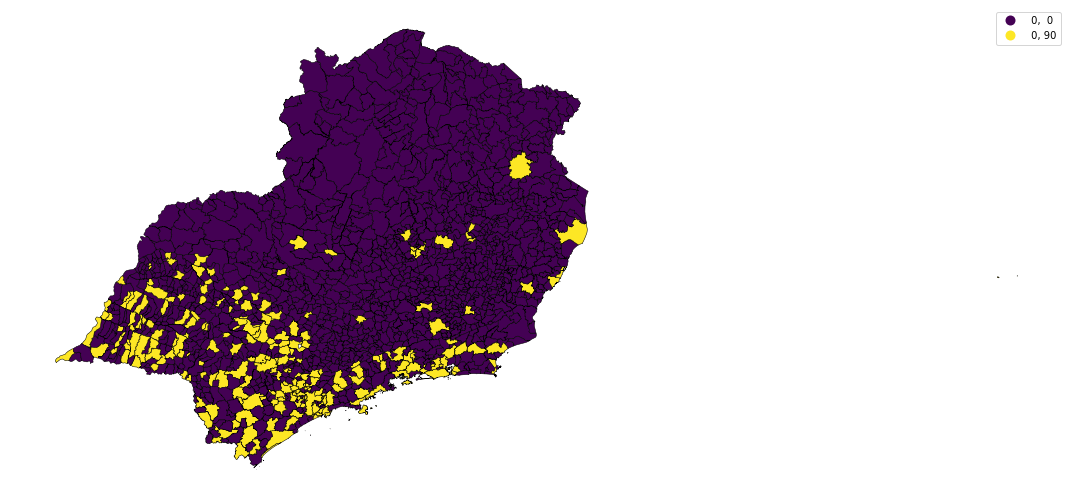

In [22]:
# Municipios da Região Sudeste que apresentam registros - Esperar Mapa ser montado
f,axs = plt.subplots(1, figsize=(15, 15))
df_shapeSudeste.plot('Qtd_Registros',scheme='Quantiles',
                     legend=True,legend_kwds={'fmt':'{:.0f}'},
                     cmap='viridis', linewidth=0.5,
                     categorical=True,
                     edgecolor='k',k=2 , ax=axs, )
axs.set_axis_off()
plt.tight_layout()



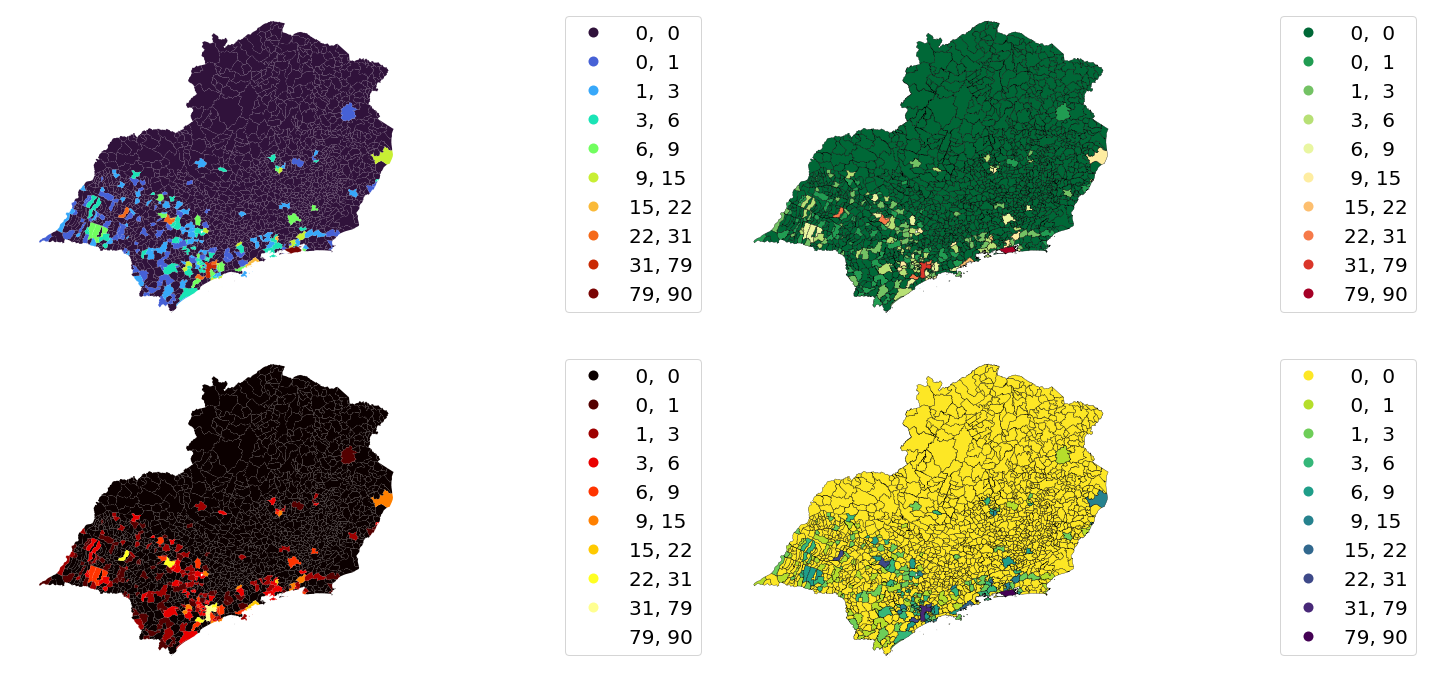

In [30]:
# Comando para pegar 100% da largura do Browser 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Temas dos mapas
maps = ['turbo', 'RdYlGn_r', 'hot','viridis_r']

# Montando e Apresentamos mapas por intervalos de registros nos municípios - Esperar mapas serem montados
f, axs = plt.subplots(2,2, figsize=(20, 10))
axs = axs.flatten()

for i in range(0,len(maps)):
    linewidth = 0.3 if i != 0 and i != 2 else 0
    df_shapeSudeste.plot('Qtd_Registros',scheme='fisher_jenks',
                         legend=True,legend_kwds={'fmt':'{:.0f}'},
                         edgecolor='k',linewidth=linewidth,
                         cmap=f'{maps[i]}',k=10, ax=axs[i])
    axs[i].set_axis_off()
    plt.tight_layout()

# OBS: Dois clicks para analisar melhor -> Zoom

In [2]:
# df_shapeSudeste.to_excel(r"/home/hector/Documentos/Fatec/DashSudeste/df_shapeSudeste.xlsx", index=False)

In [3]:
# df_dataSudeste.to_excel(r"/home/hector/Documentos/Fatec/Integrador2Tabelas/df_dataSudeste.xlsx", index=False)